## MA5851 A2 Recommender System
Anthony Lighterness, jc244913

### Introduction (Readme)
The current study implements six recommender systems, including two content-based and four collaborative-filtering approaches to recommend new products (i.e. reading titles) and new university courses (i.e. users) to new input users or fields of study. Sections 1 to 4 include cleaning, processing using natural language processing techniques, and topic modelling using Latent Dirchlet Allocation. To test the six recommender systems, new readers are encouraged to skip to section 5 and to import the necessary datasets containing the corpora for running the recommender systems. Further instructions are included at that point.

### Outline
1. Import Libraries
2. Data Import and Cleaning
3. NLP Techniques: Punctuation, Stemming, Lemmatization
4. Topic Modelling for Coursename Labelling
5. Instructions for New Readers/Users
6. User-Item Content-Based Recommender System
7. User-User Collaborative-Filtering Recommender System
8. User-User Collaborative Filtering using LDA-Labelled Courses
9. Quantitative Assessment of Recommender Systems
10. References

### 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
#from ast import literal_eval
#from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import paired_distances, cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Phrases

import nltk
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer, word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
#nltk.download()
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')
#nltk.download('wordnet')
stopwords = stopwords.words('english')

import re, string, timeit
from itertools import chain 

# pip install spacy
import spacy

%matplotlib inline
#pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim


### 2. Data Import and Cleaning

In [3]:
# Two datasets are imported:
# (1) df1 = the original and unprocessesed dataset and contains:
#      - 68,530 rows
#      - 3,675 unique courses 
#      - Uni ID counts = 2: 49,826; 3: 9,430; 4: 7,707, 3: 1,567

# (2) df_meta = processed, refined, and metadata-enriched using OpenRefine
#     df_meta contains 6,000 rows composed of:
#      - 1,500 rows from each university
#      - 2,133 unique courses

# Each of these two datasets will be used to compute two recommender systems: 
# 1) Content-based: Recommends reading titles for an input 'field of study' or 'theme'
# 2) Collaborative-Filtering: Recommends university courses for an input 'field of study' or 'theme'

# Therefore, four datasets will serve four separate recommender systems, which will be qualitatively compared.

df = '/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Datasets/MA5851 A2 Information Resources for Recommendation Engine.xlsx'
meta_df = '/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Datasets/metadata_6000.xlsx'
df = pd.read_excel(df,encoding='utf-8')
meta_df = pd.read_excel(meta_df,encoding='utf-8')


In [4]:
df1 = df.copy()
df_meta = meta_df.copy()

In [5]:
df1.head(1)

,ID,COURSENAME,ITEM_COUNT,TITLE,RESOURCE_TYPE,SUBTITLE,ISBN10S,ISBN13S,ISSNS,EISSNS,DOI,EDITION,EDITORS,PUBLISHER,DATES,VOLUME,PAGE_END,AUTHORS,Unnamed: 18
0,3,SWALLOWING ACROSS THE LIFESPAN,87.0,Archives of Otolaryngology–Head & Neck Surgery,Journal,Archives of Otolaryngology–Head & Neck Surgery,NaN,NaN,0886-4470,0886-4470,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_meta.head(1)

,Index,ID,COURSENAME,TITLE,textsnippet,subtitle2,PUBLISHER,identifier,AUTHORS,category,description,SUBTITLE,ITEM_COUNT,RESOURCE_TYPE
0,0,2,Perspectives On Health,Young Australians: Their Health And Wellbeing ...,NaN,NaN,Springer,9789812871886,"[""Katie Wright"",""Julie McLeod""]","[""Social Science""]",This volume offers a critical rethinking of th...,Young Australians: Their Health And Wellbeing ...,29,Book


In [7]:
# Duplicate df_meta: one for unique course profiles, and one for unique reading title profiles.
# This will be repeated for the original, non-metadata enriched dataset during preprocessing.
df_meta_course_grouped = df_meta.copy()
df_meta_titles_grouped = df_meta.copy()

In [8]:
df_meta_course_grouped.head(1)

,Index,ID,COURSENAME,TITLE,textsnippet,subtitle2,PUBLISHER,identifier,AUTHORS,category,description,SUBTITLE,ITEM_COUNT,RESOURCE_TYPE
0,0,2,Perspectives On Health,Young Australians: Their Health And Wellbeing ...,NaN,NaN,Springer,9789812871886,"[""Katie Wright"",""Julie McLeod""]","[""Social Science""]",This volume offers a critical rethinking of th...,Young Australians: Their Health And Wellbeing ...,29,Book


In [9]:
df_meta_titles_grouped.head(1)

,Index,ID,COURSENAME,TITLE,textsnippet,subtitle2,PUBLISHER,identifier,AUTHORS,category,description,SUBTITLE,ITEM_COUNT,RESOURCE_TYPE
0,0,2,Perspectives On Health,Young Australians: Their Health And Wellbeing ...,NaN,NaN,Springer,9789812871886,"[""Katie Wright"",""Julie McLeod""]","[""Social Science""]",This volume offers a critical rethinking of th...,Young Australians: Their Health And Wellbeing ...,29,Book


In [10]:
# UNIQUE COURSE GROUPING: Set unique coursenames as index for first two datasets 
df_meta_course_grouped.set_index('COURSENAME', inplace=True)
cols_meta_courses = df_meta_course_grouped.columns

df_meta_course_grouped['COURSES_BOW'] = df_meta_course_grouped[cols_meta_courses].\
apply(lambda row: ' '.join(row.values.astype(str)), axis=1)


In [11]:
df_meta_course_grouped.head(1)

,Index,ID,TITLE,textsnippet,subtitle2,PUBLISHER,identifier,AUTHORS,category,description,SUBTITLE,ITEM_COUNT,RESOURCE_TYPE,COURSES_BOW
COURSENAME,,,,,,,,,,,,,,
Perspectives On Health,0,2,Young Australians: Their Health And Wellbeing ...,NaN,NaN,Springer,9789812871886,"[""Katie Wright"",""Julie McLeod""]","[""Social Science""]",This volume offers a critical rethinking of th...,Young Australians: Their Health And Wellbeing ...,29,Book,0 2 Young Australians: Their Health And Wellbe...


In [12]:
# UNIQUE READING LIST GROUPING: Set unique reading titles as index for metadata-enriched dataset
df_meta_titles_grouped.set_index('TITLE', inplace=True)
cols_meta_titles = df_meta_titles_grouped.columns

df_meta_titles_grouped['TITLES_BOW'] = df_meta_titles_grouped[cols_meta_titles].\
apply(lambda row: ' '.join(row.values.astype(str)), axis=1)


In [13]:
df_meta_titles_grouped.head(1)

,Index,ID,COURSENAME,textsnippet,subtitle2,PUBLISHER,identifier,AUTHORS,category,description,SUBTITLE,ITEM_COUNT,RESOURCE_TYPE,TITLES_BOW
TITLE,,,,,,,,,,,,,,
Young Australians: Their Health And Wellbeing 2011 (aihw),0,2,Perspectives On Health,NaN,NaN,Springer,9789812871886,"[""Katie Wright"",""Julie McLeod""]","[""Social Science""]",This volume offers a critical rethinking of th...,Young Australians: Their Health And Wellbeing ...,29,Book,0 2 Perspectives On Health nan nan Springer 97...


In [14]:
df_meta_course_grouped2 = df_meta_course_grouped.copy()

df_meta_titles_grouped2 = df_meta_titles_grouped.copy()


In [15]:
df_meta_course_BOW = df_meta_course_grouped2[['COURSES_BOW']]

df_meta_titles_BOW = df_meta_titles_grouped2[['TITLES_BOW']]


In [16]:
df_meta_course_BOW.head(1)

,COURSES_BOW
COURSENAME,
Perspectives On Health,0 2 Young Australians: Their Health And Wellbe...


In [17]:
df_meta_titles_BOW.head(1)

,TITLES_BOW
TITLE,
Young Australians: Their Health And Wellbeing 2011 (aihw),0 2 Perspectives On Health nan nan Springer 97...


In [18]:
# Redefine metadata dataframes
df_meta_course_BOW2 = df_meta_course_BOW.copy()
df_meta_titles_BOW2 = df_meta_titles_BOW.copy()

In [19]:
# Group by indices for each metadata dataframe
df_meta_course_BOW3 = df_meta_course_BOW2.groupby(df_meta_course_BOW2.index).sum()
df_meta_titles_BOW3 = df_meta_titles_BOW2.groupby(df_meta_titles_BOW2.index).sum()


In [20]:
df_meta_course_BOW3.head(2)

,COURSES_BOW
COURSENAME,
20th Century Design,4667 5 Modern Furniture Classics nan nan Watso...
21st Century Challenges,4553 5 a Users Guide To The Crisis Of Civiliza...


In [21]:
df_meta_titles_BOW3.head(2)

,TITLES_BOW
TITLE,
10 Questions To Ask Before Joining A Co-working Space,202 2 Business Of Freelancing nan nan Simon an...
2016 Nissan Titan Xd | Shoulders Of Giants,1113 2 Global Media Communication nan nan Rowm...


In [22]:
df2 = df1.copy()

In [23]:
# Rename columns for df1
df2 = df2[['ID', 'COURSENAME', 'TITLE', 'RESOURCE_TYPE', 
           'SUBTITLE','ISBN10S','ISBN13S','ISSNS','DOI',
           'EDITORS','AUTHORS','Unnamed: 18']].drop('AUTHORS',1)


In [24]:
# Rename column to Author
df2.rename(columns = {'Unnamed: 18':'AUTHOR'},inplace=True)


In [25]:
# Redefine original dataframe
df3 = df2.copy()

In [26]:
df3.head(2)


,ID,COURSENAME,TITLE,RESOURCE_TYPE,SUBTITLE,ISBN10S,ISBN13S,ISSNS,DOI,EDITORS,AUTHOR
0,3,SWALLOWING ACROSS THE LIFESPAN,Archives of Otolaryngology–Head & Neck Surgery,Journal,Archives of Otolaryngology–Head & Neck Surgery,NaN,NaN,0886-4470,NaN,[],NaN
1,3,SWALLOWING ACROSS THE LIFESPAN,Cold Spring Harbor Perspectives in Medicine,Journal,Cold Spring Harbor Perspectives in Medicine,NaN,NaN,NaN,NaN,[],NaN


In [27]:
# Clean RESOURCE_TYPE
# First define string data types
df3['RESOURCE_TYPE']=df3['RESOURCE_TYPE'].astype(str)
df3['COURSENAME']=df3['COURSENAME'].astype(str)
df3['TITLE']=df3['TITLE'].astype(str)
df3['SUBTITLE']=df3['SUBTITLE'].astype(str)

# Replace incoherent values with assumed relevant categories
# replace_resources = ['illustration','music','dvd']
df3.loc[df3['RESOURCE_TYPE'].str.contains('illustration', case=False),'RESOURCE_TYPE'] = 'Image'
df3.loc[df3['RESOURCE_TYPE'].str.contains('music', case=False), 'RESOURCE_TYPE'] = 'AudioDocument'
df3.loc[df3['RESOURCE_TYPE'].str.contains('dvd', case=False), 'RESOURCE_TYPE'] = 'AudioVisualDocument'
df3.loc[df3['RESOURCE_TYPE'].str.contains('cd', case=False), 'RESOURCE_TYPE'] = 'AudioDocument'
df3.loc[df3['RESOURCE_TYPE'].str.contains('ill', case=False), 'RESOURCE_TYPE'] = 'Image'
df3.loc[df3['RESOURCE_TYPE'].str.contains('disc', case=False), 'RESOURCE_TYPE'] = 'AudioVisualDocument'
df3.loc[df3['RESOURCE_TYPE'].str.contains('online', case=False), 'RESOURCE_TYPE'] = 'OnlineResource'
df3.loc[df3['RESOURCE_TYPE'].str.contains('pages', case=False), 'RESOURCE_TYPE'] = 'Page'
df3.loc[df3['RESOURCE_TYPE'].str.contains('paging', case=False), 'RESOURCE_TYPE'] = 'Page'
df3.loc[df3['RESOURCE_TYPE'].str.contains('video', case=False), 'RESOURCE_TYPE'] = 'AudioVisualDocument'
df3.loc[df3['RESOURCE_TYPE'].str.contains('electronic', case=False), 'RESOURCE_TYPE'] = 'Book'
df3.loc[df3['RESOURCE_TYPE'].str.contains('vol', case=False), 'RESOURCE_TYPE'] = 'Book'
df3.loc[df3['RESOURCE_TYPE'].str.contains('cm', case=False), 'RESOURCE_TYPE'] = 'Image'
df3.loc[df3['RESOURCE_TYPE'].str.contains('figure', case=False), 'RESOURCE_TYPE'] = 'Image'
df3.loc[df3['RESOURCE_TYPE'].str.contains('p.', case=False), 'RESOURCE_TYPE'] = 'Book'
df3.loc[df3['RESOURCE_TYPE'].str.contains('v.', case=False), 'RESOURCE_TYPE'] = 'Book'
df3.loc[df3['RESOURCE_TYPE'].str.contains('nan', case=False), 'RESOURCE_TYPE'] = 'NaN'
df3.loc[df3['RESOURCE_TYPE'].str.contains('audiodocument', case=False), 'RESOURCE_TYPE'] = 'AudioDocument'


In [28]:
# Copy cleaned dataframe
df3_clean = df3.copy()
df3_clean.head(1)

,ID,COURSENAME,TITLE,RESOURCE_TYPE,SUBTITLE,ISBN10S,ISBN13S,ISSNS,DOI,EDITORS,AUTHOR
0,3,SWALLOWING ACROSS THE LIFESPAN,Archives of Otolaryngology–Head & Neck Surgery,Journal,Archives of Otolaryngology–Head & Neck Surgery,NaN,NaN,0886-4470,NaN,[],NaN


In [29]:
# Remove special characters from Title and Subtitle
df3_clean['TITLE']=df3_clean['TITLE'].str.replace(r'[^\w\s]+', ' ')
df3_clean['SUBTITLE']=df3_clean['SUBTITLE'].str.replace(r'[^\w\s]+', ' ')


In [30]:
# Copy to a new dataframe
df3_clean2 = df3_clean.copy()
df3_clean2.head(1)

,ID,COURSENAME,TITLE,RESOURCE_TYPE,SUBTITLE,ISBN10S,ISBN13S,ISSNS,DOI,EDITORS,AUTHOR
0,3,SWALLOWING ACROSS THE LIFESPAN,Archives of Otolaryngology Head Neck Surgery,Journal,Archives of Otolaryngology Head Neck Surgery,NaN,NaN,0886-4470,NaN,[],NaN


In [31]:
# Re-establish column names, duplicating into two dataframes: one for unique COURSES, and one for unique TITLES
# Use Title, Resource Type, and Subtitle as 'metadata' to describe content for unique courses
courses_df = df3_clean2.copy()

courses_df = courses_df[['TITLE','COURSENAME','RESOURCE_TYPE','SUBTITLE']]

# Maintain all columns - extra columns will be kept as metadata for titles
titles_df = df3_clean2.copy()


In [32]:
# UNIQUE COURSES df: group by unique coursename as index to form bag-of-words (BOW) and soup for each course
courses_df.set_index('COURSENAME', inplace=True)
cols1 = courses_df.columns

# UNIQUE TITLES df: group unique titles as index
titles_df.set_index('TITLE', inplace=True)
cols2 = titles_df.columns


In [33]:
# Create BOW for each course
courses_df['BOW_COURSES'] = courses_df[cols1].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Create BOW for each title
titles_df['BOW_TITLES'] = titles_df[cols2].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)


In [34]:
courses_df2 = pd.DataFrame(courses_df).copy()
courses_df2 = courses_df2[['BOW_COURSES']]

titles_df2 = pd.DataFrame(titles_df).copy()
titles_df2 = titles_df2[['BOW_TITLES']]
titles_all = titles_df.copy()

In [35]:
courses_df3 = courses_df2.copy()
titles_df3 = titles_df2.copy()

In [36]:
# Group by indices so each row is represented by unique TITLE or COURSE
courses_df3 = courses_df3.groupby(courses_df3.index).sum()
titles_df3 = titles_df3.groupby(titles_df3.index).sum()


### 3. NLP Techniques: Punctuation, Stemming, Lemmatization

In [37]:
from nltk.corpus import wordnet, stopwords
from nltk.stem.snowball import SnowballStemmer

# Define stop words to be removed
stop_words = stopwords.words('english')
set(stop_words)
# Extend stop words for this particular context
stop_words.extend(["the ", " and ", "of ", " in ",
                 " na ", " nan ", "for ", "introduction", 
                   "book", "image", "journal"])

# Define lemmatizer and Stemmer
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer(language='english')

# Function to prepare Bag-of-Words 
def preprocess(sentence):
    sentence = str(sentence)
    
    # Coerce to lowercase
    sentence = sentence.lower()
    
    # Remove stubborn NA values
    sentence = sentence.replace('nan',"")
    sentence = sentence.replace(' na ',"")
    
    # Ensure special characters are removed
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    
    # Remove numeric values
    no_num = re.sub('[0-9]+', '', cleantext)
    
    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(no_num)
    
    # Remove stopwords defined above
    no_stops = [w for w in tokens if len(w) > 2 if not w in stop_words]
    
    # Stemming
    stem_words=[stemmer.stem(w) for w in no_stops]
    
    # Lemmatization
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    
    return " ".join(lemma_words)


In [38]:
# Make copies of dataframes
meta_courses = df_meta_course_BOW3.copy()
meta_titles = df_meta_titles_BOW3.copy()


In [39]:
courses_df4=courses_df3.copy()
titles_df4=titles_df3.copy()

In [40]:
# Clean/preprocess the BOW's for all four dataframes
# Non-enriched dataframes
courses_df4['BOW_COURSES'] = courses_df4['BOW_COURSES'].map(lambda s:preprocess(s))
titles_df4['BOW_TITLES'] = titles_df4['BOW_TITLES'].map(lambda s:preprocess(s))

# Metadata enriched dataframes
meta_courses['COURSES_BOW'] = meta_courses['COURSES_BOW'].map(lambda s:preprocess(s))
meta_titles['TITLES_BOW'] = meta_titles['TITLES_BOW'].map(lambda s:preprocess(s))


In [41]:
# Make copies of dataframes
courses_df5 = courses_df4.copy()
titles_df5 = titles_df4.copy()

meta_courses2 = meta_courses.copy()
meta_titles2 = meta_titles.copy()


In [42]:
# Reset indices
titles_recsys = titles_df5.reset_index()
meta_titles_recsys = meta_titles.reset_index()


### 4. Topic Modelling for Coursename Labelling

In [43]:
# Compute Latent Dirchlet Allocation for Topic Modelling and labelling of unique COURSES
courses_LDA = courses_df5.copy()
meta_courses_LDA = meta_courses2.copy()

In [45]:
# Re-tokenize sentences
courses_LDA['tokens'] = courses_LDA['BOW_COURSES'].map(sent_tokenize)

meta_courses_LDA['tokens'] = meta_courses_LDA['COURSES_BOW'].map(sent_tokenize)


In [46]:
# Re-tokenize words
courses_LDA['tokens'] = courses_LDA['tokens'].map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])

meta_courses_LDA['tokens'] = meta_courses_LDA['tokens'].map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])


In [48]:
# Make backup copies of dataframes
courses_LDA2 = courses_LDA.copy()
meta_courses_LDA2 = meta_courses_LDA.copy()

In [49]:
# Flatten list of tokens using chain
courses_LDA2['tokens'] = courses_LDA2['tokens'].map(lambda sentences: list(chain.from_iterable(sentences)))
meta_courses_LDA2['tokens'] = meta_courses_LDA2['tokens'].map(lambda sentences: list(chain.from_iterable(sentences)))


In [50]:
# Compute grammar dependency n-grams for both dataframes
tokens_courses = courses_LDA2['tokens'].tolist()
bigram_courses = Phrases(tokens_courses)
trigram_courses = Phrases(bigram_courses[tokens_courses], min_count=1)
tokens_courses = list(trigram_courses[bigram_courses[tokens_courses]])


In [51]:
tokens_metacourses = meta_courses_LDA2['tokens'].tolist()
bigram_metacourses = Phrases(tokens_metacourses)
trigram_metacourses = Phrases(bigram_metacourses[tokens_metacourses], min_count=1)
tokens_metacourses = list(trigram_metacourses[bigram_metacourses[tokens_metacourses]])


In [53]:
# Collect LDA dictionary for both dataframes
dict_LDA = corpora.Dictionary(tokens_courses)
dict_LDA.filter_extremes(no_below=3)
corpus = [dict_LDA.doc2bow(tok) for tok in tokens_courses]


In [54]:
meta_dict_LDA = corpora.Dictionary(tokens_metacourses)
meta_dict_LDA.filter_extremes(no_below=3)
corpus_meta = [meta_dict_LDA.doc2bow(tok) for tok in tokens_metacourses]


In [55]:
# Construct LDA model for both coursename dataframes
np.random.seed(0)
# Specify number of topics at 20
num_topics = 20
lda_model = models.LdaModel(corpus, num_topics = num_topics,
                            id2word=dict_LDA,
                            passes = 4,
                            alpha = [0.01]*num_topics,
                            eta = [0.01]*len(dict_LDA.keys()))


In [56]:
np.random.seed(0)
lda_model_meta = models.LdaModel(corpus_meta, 
                                 num_topics = num_topics,
                                 id2word = meta_dict_LDA,
                                 passes = 4, 
                                 alpha = [0.01]*num_topics,
                                 eta = [0.01]*len(meta_dict_LDA.keys()))


In [57]:
# Print the contributions of word tokens to each topic 
for i,topic in lda_model.show_topics(formatted = True, 
                                     num_topics = num_topics, 
                                     num_words = 20):
    print(str(i)+": "+ topic)
    print()


0: 0.055*"articl" + 0.031*"human" + 0.020*"chapter" + 0.017*"indonesia" + 0.017*"econom" + 0.016*"histori" + 0.015*"intellig" + 0.015*"patholog" + 0.015*"anim" + 0.014*"diseas" + 0.014*"biolog" + 0.013*"ecolog" + 0.013*"secur" + 0.013*"conserv" + 0.010*"nutrit" + 0.009*"foot" + 0.009*"cold_war" + 0.009*"evolut" + 0.008*"state" + 0.007*"polit"

1: 0.129*"manag" + 0.022*"organ" + 0.018*"leadership" + 0.016*"chapter" + 0.016*"articl" + 0.015*"develop" + 0.015*"practic" + 0.014*"busi" + 0.013*"intern" + 0.013*"strategi" + 0.009*"chang" + 0.008*"review" + 0.008*"work" + 0.008*"research" + 0.008*"human_resourc_manag" + 0.007*"behavior" + 0.007*"environment" + 0.006*"approach" + 0.006*"learn" + 0.006*"system"

2: 0.097*"design" + 0.031*"onlineresourc" + 0.022*"scienc" + 0.015*"research" + 0.014*"principl" + 0.012*"analysi" + 0.012*"approach" + 0.012*"chapter" + 0.011*"physic" + 0.011*"teach" + 0.011*"write" + 0.010*"guid" + 0.009*"languag" + 0.009*"handbook" + 0.009*"studi" + 0.009*"visual" +

In [58]:
# Visualise contributions of word tokens to each topic 
for i,topic in lda_model_meta.show_topics(formatted = True, 
                                     num_topics = num_topics, 
                                     num_words = 20):
    print(str(i)+": "+ topic)
    print()


0: 0.033*"educ" + 0.025*"learn" + 0.022*"practic" + 0.018*"learn_teach" + 0.017*"manag" + 0.015*"secondari_school" + 0.014*"includ" + 0.014*"work" + 0.013*"teacher_educ" + 0.013*"unit" + 0.013*"school" + 0.013*"teacher" + 0.012*"base" + 0.011*"understand" + 0.011*"student" + 0.010*"transform" + 0.010*"provid" + 0.009*"new" + 0.009*"cours" + 0.009*"help"

1: 0.061*"tourism" + 0.039*"market" + 0.037*"research" + 0.021*"soviet" + 0.019*"travel" + 0.019*"tourist" + 0.017*"advertis" + 0.016*"brand" + 0.012*"second" + 0.012*"author" + 0.011*"refus" + 0.011*"screenplay" + 0.009*"manag" + 0.008*"visitor" + 0.008*"power" + 0.007*"one" + 0.007*"use" + 0.007*"adopt" + 0.007*"social_medium" + 0.007*"major"

2: 0.026*"design" + 0.020*"intern" + 0.018*"manag" + 0.017*"econom" + 0.017*"engin" + 0.015*"use" + 0.012*"ass" + 0.010*"profession" + 0.010*"analysi" + 0.009*"system" + 0.009*"guid" + 0.009*"process" + 0.007*"relat" + 0.007*"market" + 0.007*"prepar" + 0.006*"project" + 0.006*"focus" + 0.006*"p

In [59]:
# Retrieve dominant topics for each course of both dataframes
#data_topics_new = lda_model
topics = [lda_model[corpus[i]] for i in range(len(courses_LDA2))]

topics_meta = [lda_model_meta[corpus_meta[i]] for i in range(len(meta_courses_LDA))]


In [60]:
# Function to retrieve topics for courses
def topics_doc_to_df(topics_doc, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_doc:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res


In [61]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
doc_topic = pd.concat([topics_doc_to_df(topics_doc,
                                        num_topics=num_topics)
                       for topics_doc in topics]) \
.reset_index(drop=True).fillna(0)


In [62]:
# topic weighting matrix for metadata-enriched df
doc_topic_meta = pd.concat([topics_doc_to_df(topics_doc_meta,
                                    num_topics=num_topics)
                        for topics_doc_meta in topics_meta]) \
.reset_index(drop=True).fillna(0)


In [63]:
# Visualise sparse matrix of topics in each course/document 
doc_topic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.381478,0.000000,0.0,0.000000,0.137306,0.0,0.189167,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.222503,0.0,0.064574,0.0,0.000000
1,0.000000,0.000000,0.0,0.303079,0.000000,0.0,0.000000,0.0,0.596146,0.0,0.0,0.0,0.0,0.000000,0.0,0.098626,0.0,0.000000,0.0,0.000000
2,0.000000,0.188266,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.799056,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.954753,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.913613


In [66]:
# Define dataframe structures for topics in each course
course_topics = pd.DataFrame(doc_topic.idxmax(axis=1).sort_values())

course_topics_meta = pd.DataFrame(doc_topic_meta.idxmax(axis=1).sort_values())


In [67]:
# Make copies and reset indices for dataframes
courses_LDA3 = courses_LDA2.copy()
courses_LDA3 = courses_LDA3.reset_index()

meta_courses_LDA3 = meta_courses_LDA2.copy()
meta_courses_LDA3 = meta_courses_LDA3.reset_index()


In [69]:
# Rename column names
courses_LDA3_label = courses_LDA3.copy()
courses_LDA3_label = courses_LDA3[['COURSENAME','BOW_COURSES','tokens']]

meta_courses_LDA3_label = meta_courses_LDA3.copy()
meta_courses_LDA3_label = meta_courses_LDA3[['COURSENAME','COURSES_BOW','tokens']]

In [70]:
course_topics_2 = course_topics.copy()
course_topics_meta2 = course_topics_meta.copy()

In [71]:
# Join coursenames with respective cluster allocations based on index
course_topics_join = pd.merge(course_topics_2,courses_LDA3_label,
                              left_index=True,right_index=True)
course_topics_join.head(1)

,0,COURSENAME,BOW_COURSES,tokens
0,0,A Global History,oxford handbook cold war oxford handbook cold ...,"[oxford, handbook, cold, war, oxford, handbook..."


In [72]:
# Repeat for metadata dataframe
course_topics_join_meta = pd.merge(course_topics_meta2,meta_courses_LDA3_label,
                              left_index=True,right_index=True)
course_topics_join_meta.head(1)

,0,COURSENAME,COURSES_BOW,tokens
1307,0,"Mathematics, Numeracy And Learner Engagement B",australian mathemat teacher uom mathemat austr...,"[australian, mathemat, teacher, uom, mathemat,..."


In [73]:
# Redefine dataframes
course_topics_labels = course_topics_join.copy()
course_topics_meta_labels = course_topics_join_meta.copy()

In [74]:
# Rename column names
course_topics_labels.columns = ['CLUSTER_NUM','COURSENAME','BOW_CLEAN','TOKENS']
course_topics_meta_labels.columns = ['CLUSTER_NUM','COURSENAME','BOW_CLEAN','TOKENS']


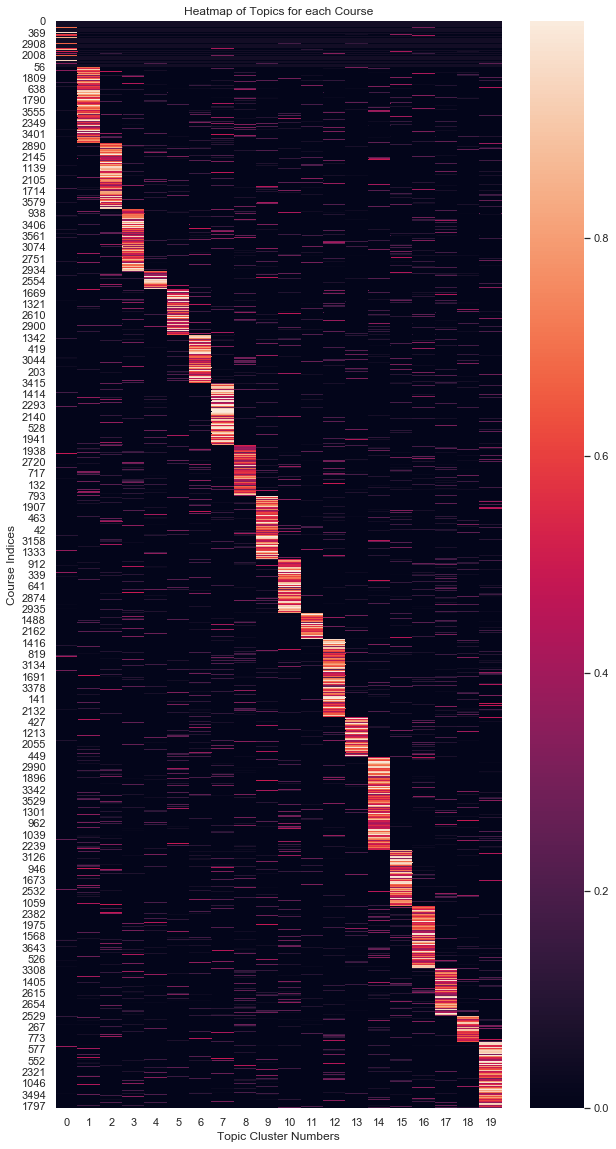

In [552]:
# Visualise dominant topic allocation for each coursename from original dataframe
# The topic modelling visuals (heatmap, topic counts and LDAvis) were adapted from McAllister et al. (2019)

%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
ax = plt.axes()

sns_heatmap1 = sns.heatmap(doc_topic.loc[doc_topic.idxmax(axis=1).\
                                         sort_values().index],ax=ax)
ax.set_title('Heatmap of Topics for each Course')
sns_heatmap1.set(xlabel='Topic Cluster Numbers', ylabel='Course Indices')

sns_heatmap1.figure.savefig("courses_heatmap.png")


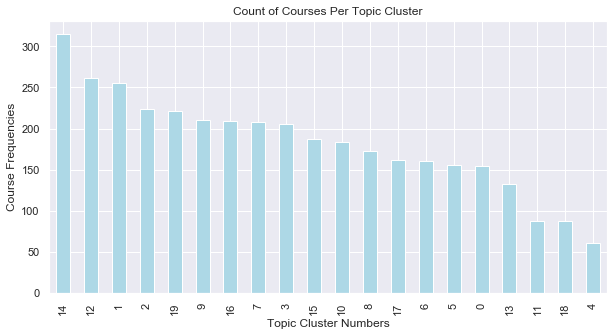

In [548]:
# Visualise topics by frequency of courses
sns.set(rc={'figure.figsize':(10,5)})
ax = plt.axes()
barplot1=doc_topic.idxmax(axis=1).value_counts().\
plot.bar(color='lightblue',ax=ax)
ax.set_title('Count of Courses Per Topic Cluster')
barplot1.set(xlabel='Topic Cluster Numbers', ylabel='Course Frequencies')

barplot1.figure.savefig("barplot_topics.png")

In [77]:
# Visualise Principal Component dimensionally reduced topic distributions
#   - Size of bubble indicates proportions of topics across the sum tokens in the corpus
#   - Red bars estimate the frequency that a term was generated by a given topic
#   - Blue bars are the overall frequencies of each term in the corpus
#   - Adjustable lambda gives the relevance score of each term for a topic
#   - Source indicates lambda is most accurate at ~0.7 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
#   - Adapted from McAllister et al. (2019)
# pip install pyLDAvis
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, 
                              corpus=corpus, 
                              dictionary=dict_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

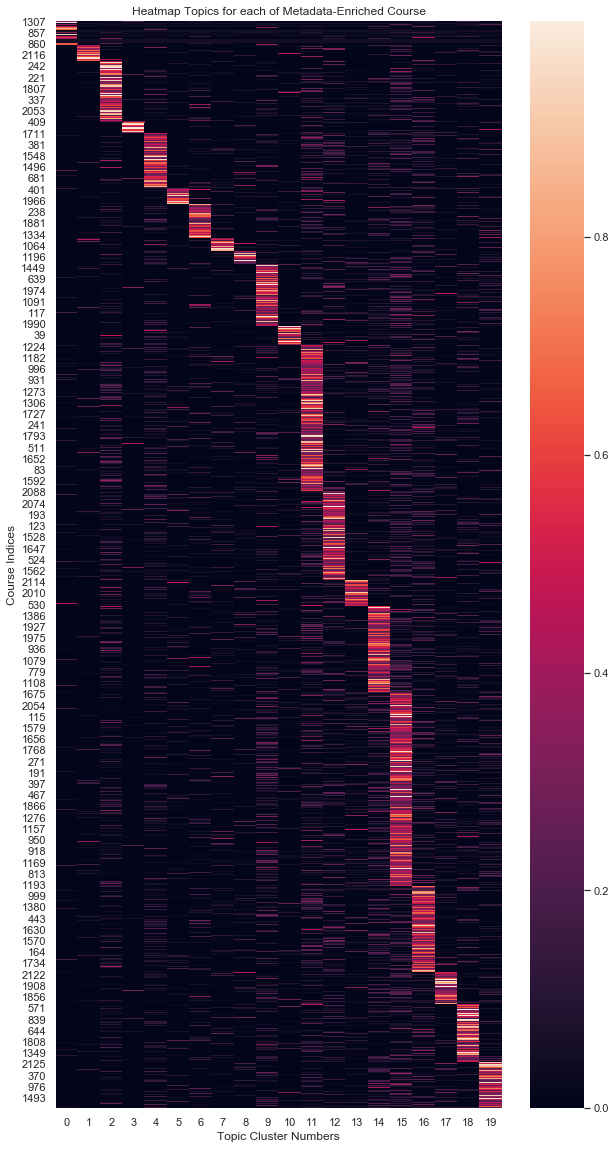

In [550]:
# Repeat analysis for metadata dataframe
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
ax = plt.axes()

sns_heatmap2 = sns.heatmap(doc_topic_meta.loc[doc_topic_meta.idxmax(axis=1).\
                                            sort_values().index],ax=ax)
ax.set_title('Heatmap Topics for each of Metadata-Enriched Course')
sns_heatmap2.set(xlabel='Topic Cluster Numbers', ylabel='Course Indices')

sns_heatmap2.figure.savefig("courses_heatmap_meta.png")


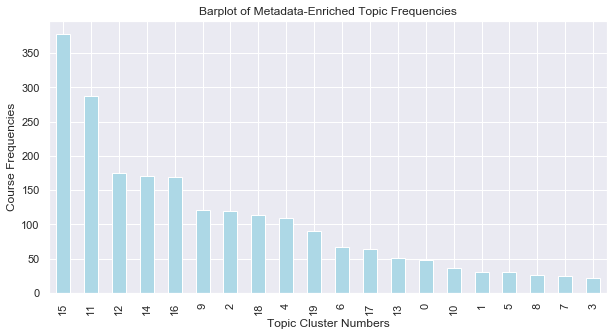

In [553]:
sns.set(rc={'figure.figsize':(10,5)})
ax = plt.axes()
barplot2 = doc_topic_meta.idxmax(axis=1).value_counts().\
plot.bar(color='lightblue', ax=ax)
ax.set_title('Barplot of Metadata-Enriched Topic Frequencies')
barplot2.set(xlabel='Topic Cluster Numbers', ylabel='Course Frequencies')

barplot2.figure.savefig("barplot_topics_meta.png")


In [80]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis_meta = pyLDAvis.gensim.prepare(topic_model=lda_model_meta, 
                                   corpus=corpus_meta, 
                                   dictionary=meta_dict_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_meta)

In [83]:
# Using the PCA dimensionally reduced topic visualisations, 
#   each cluster is manually assigned a field of study
df_cluster_names2 = course_topics_labels.copy()
df_meta_clusters2 = course_topics_meta_labels.copy()


In [84]:
df_cluster_names2['CLUSTER_NUM']=df_cluster_names2.CLUSTER_NUM.astype(str)
df_meta_clusters2['CLUSTER_NUM']=df_meta_clusters2.CLUSTER_NUM.astype(str)


In [85]:
# Allocate each cluster a specific field of study based on dominant themes
# Use dictionary format
clust_dict = {'0':'Health Science','1':'Education','2':'Business','3':'Social Science','4':'Clinical Health Science',
              '5':'Environmental Science','6':'Economics','7':'Public Health','8':'Economics',
              '9':'Law','10':'Psychology','11':'Business','12':'Indigenous Health',
              '13':'Economics','14':'Humanities','15':'Engineering','16':'Law',
              '17':'Project Management','18':'Public Health','19':'Engineering'} 

clust_dict_meta = {'0':'Sociology','1':'Business','2':'Education','3':'Law','4':'Humanities',
                   '5':'Clinical Health Science','6':'Education','7':'Sociology','8':'Economics',
                   '9':'Humanities','10':'Sociology','11':'Humanities','12':'Nursing',
                   '13':'Education','14':'Social Science','15':'Environmental Science','16':'Engineering',
                   '17':'Education','18':'Economics','19':'Health Science'} 

df_cluster_names2['CLUSTER_NUM'].replace(clust_dict, inplace=True)
df_meta_clusters2['CLUSTER_NUM'].replace(clust_dict_meta, inplace=True)


In [86]:
df_meta_clusters2.head(1)


,CLUSTER_NUM,COURSENAME,BOW_CLEAN,TOKENS
1307,Sociology,"Mathematics, Numeracy And Learner Engagement B",australian mathemat teacher uom mathemat austr...,"[australian, mathemat, teacher, uom, mathemat,..."


In [87]:
# Rename labelled dataframe columns
df_cluster_names2.columns = ['Study_Field','Coursename','Clean_BOW','Tokens']
df_meta_clusters2.columns = ['Study_Field','Coursename','Clean_BOW','Tokens']

In [88]:
df_labelled = df_cluster_names2
df_labelled_meta = df_meta_clusters2

In [89]:
# Re-organise indices in ascending order
df_labelled.sort_index(inplace=True)
df_labelled_meta.sort_index(inplace=True)


In [90]:
# Output and Save CSV of Labelled Datasets
#df_labelled.to_csv(r'/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Datasets/df_label.csv')
#df_labelled_meta.to_csv(r'/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Datasets/df_label_meta.csv')


### 5. Instructions for New Readers
New readers are instructed to import the prepared datasets containing the corpora that support the six recommender systems. Please ensure the working directories are adjusted below before importing these datasets. It is also important to activate the user defined function called 'preprocess' to ensure the recommender systems can access this function, which is also placed after the data import below.

In [8]:
# Import datasets for Recommender Systems (PLEASE TAKE CARE TO ENSURE FILENAMES ARE MAINTAINED)
# Please un-comment by removing the hashtags and ensure the correct file directories are substituted

#df_labelled = '/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Datasets/df_label.csv'
#df_labelled_meta = '/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Datasets/df_label_meta.csv'
#titles_recsys = '/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Datasets/titles_recsys.csv'
#meta_titles_recsys = '/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Datasets/meta_titles_recsys.csv'
#df_labelled2 = '/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Datasets/df_labelled2.csv'
#df_labelled_meta2 = '/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Datasets/df_labelled_meta2.csv'

#df_labelled = pd.read_csv(df_labelled)
#df_labelled_meta = pd.read_csv(df_labelled_meta)
#titles_recsys = pd.read_csv(titles_recsys)
#meta_titles_recsys = pd.read_csv(meta_titles_recsys)
#df_labelled2 = pd.read_csv(df_labelled2)
#df_labelled_meta2 = pd.read_csv(df_labelled_meta2)


In [9]:
# PREPROCESS USER FUNCTION (Please run for new readers)
from nltk.corpus import wordnet, stopwords
from nltk.stem.snowball import SnowballStemmer

# Define stop words to be removed
stop_words = stopwords.words('english')
set(stop_words)
# Extend stop words for this particular context
stop_words.extend(["the ", " and ", "of ", " in ",
                 " na ", " nan ", "for ", "introduction", 
                   "book", "image", "journal"])

# Define lemmatizer and Stemmer
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer(language='english')

# Function to prepare Bag-of-Words 
def preprocess(sentence):
    sentence = str(sentence)
    
    # Coerce to lowercase
    sentence = sentence.lower()
    
    # Remove stubborn NA values
    sentence = sentence.replace('nan',"")
    sentence = sentence.replace(' na ',"")
    
    # Ensure special characters are removed
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    
    # Remove numeric values
    no_num = re.sub('[0-9]+', '', cleantext)
    
    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(no_num)
    
    # Remove stopwords defined above
    no_stops = [w for w in tokens if len(w) > 2 if not w in stop_words]
    
    # Stemming
    stem_words=[stemmer.stem(w) for w in no_stops]
    
    # Lemmatization
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    
    return " ".join(lemma_words)


### 6. User-Item Content-Based Recommender System

In [10]:
def recommend_reading(new_read):
    """
    Input: "input new course or subject field of study"
    Returns: "recommended relevant reading titles"
    """
    # Preprocess input
    new_read2 = pd.Series(new_read)
    new_read2 = new_read2.map(lambda s:preprocess(s))
    
    # Vectorize data
    tokenizer = TfidfVectorizer()
    tfidf_soup = tokenizer.fit_transform(soup)
    tfidf_new = tokenizer.transform(new_read2)
    
    # Store cosine similarity into a dataframe
    X = pd.DataFrame(cosine_similarity(tfidf_new,tfidf_soup), 
                     columns=soup.index).transpose().reset_index()
    
    # Return dataframe of results
    score = pd.merge(X, rec_names, left_index=True,
                    right_index=True)
    score.columns = ['Index','Score','TITLE']
    score = score[['Index','TITLE','Score']]
    
    # Compute Descriptive statistics of Scores equal to or greater than 0.4
    pass_sims = score[score['Score']>=0.4]
    print(pass_sims.Score.count(),"recommendations above 0.4 similarity were found")
    print("Minimum:",pass_sims.Score.min())
    print("Maximum:",pass_sims.Score.max())
    print("Median:",pass_sims.Score.median())
    print("IQR:",(pass_sims.Score.quantile(0.75)-pass_sims.Score.quantile(0.25)))
    
    print("Your top 30 recommendations for","'"+new_read+"'","are:")
    return score.sort_values('Score',ascending=False).head(30)


##### Instructions: 
Please enter a string indicating a field of study of interest where indicated in brackets, i.e. recommend_reading("___input___").

In [11]:
soup = titles_recsys[('BOW_TITLES')]
rec_names = titles_recsys['TITLE']

# Please replace "environmental science" with another field of study of interest.
recommend_reading("environmental science")

109 recommendations above 0.4 similarity were found
Minimum: 0.403898414529492
Maximum: 0.7429914612844974
Median: 0.44675621354982065
IQR: 0.08235990143282956
Your top 30 recommendations for 'environmental science' are:


,Index,TITLE,Score
14435,14435,Environmental Science Policy,0.742991
14437,14437,Environmental Sciences,0.676657
32809,32809,Science,0.669180
14436,14436,Environmental Science Technology,0.605496
21204,21204,Introduction to environmental engineering and ...,0.604878
22452,22452,Journal of Regional Science,0.595963
32818,32818,Science Education,0.592109
14417,14417,Environmental Management,0.575302
22092,22092,Journal of Environmental Management,0.553928
15011,15011,European Political Science,0.550735


In [12]:
soup = meta_titles_recsys[('TITLES_BOW')]
rec_names = meta_titles_recsys['TITLE']

# Please replace "environmental science" with another field of study of interest.
recommend_reading("environmental science")


5 recommendations above 0.4 similarity were found
Minimum: 0.41007925835704273
Maximum: 0.4772143817656928
Median: 0.4336319011796767
IQR: 0.04582350272139618
Your top 30 recommendations for 'environmental science' are:


,Index,TITLE,Score
896,896,Communicating In The Health Sciences,0.477214
3584,3584,Second International Handbook Of Science Educa...,0.456684
3928,3928,Teaching Primary Science Constructively,0.433632
3684,3684,Social Science & Medicine,0.410860
61,61,A Sense Of Wonder : Science In Early Childhood...,0.410079
3575,3575,Science For Children : Developing A Personal A...,0.391202
968,968,Connecting With Science Education,0.389561
1415,1415,Empirical Studies To Build A Science Of Comput...,0.376919
322,322,Ase Guide To Primary Science Education,0.375613
1493,1493,Essential Environmental Science: Methods & Tec...,0.367119


### 7. User-User Collaborative-Filtering Recommender System

In [13]:
def recommend_course(new_course):
    """
    Input: "input subject field of study or interest"
    Returns: "relevant recommended courses"
    """
    # Preprocess input
    new_course2 = pd.Series(new_course)
    new_course2 = new_course2.map(lambda s:preprocess(s))
    
    # Vectorize data
    tokenizer = TfidfVectorizer()
    tfidf_soup = tokenizer.fit_transform(soup)
    tfidf_new = tokenizer.transform(new_course2)
    X = pd.DataFrame(cosine_similarity(tfidf_new,tfidf_soup), 
                     columns=soup.index).transpose().reset_index()
    
    # Return dataframe of results
    score = pd.merge(X, rec_names, left_index=True,
                    right_index=True)
    score.columns = ['Index','Score','Coursename']
    score = score[['Index','Coursename','Score']]
    
    # Compute Descriptive statistics of Scores equal to or greater than 0.4
    pass_sims = score[score['Score']>=0.4]
    print(pass_sims.Score.count(),"recommendations above 0.4 similarity were found")
    print("Minimum:",pass_sims.Score.min())
    print("Maximum:",pass_sims.Score.max())
    print("Median:",pass_sims.Score.median())
    print("IQR:",(pass_sims.Score.quantile(0.75)-pass_sims.Score.quantile(0.25)))

    print("Your top 30 recommendations for","'"+new_course+"'","are:")
    return score.sort_values('Score',ascending=False).head(30)


In [14]:
soup = df_labelled[('Clean_BOW')]
rec_names = df_labelled['Coursename']

# Please replace "environmental science" with another field of study of interest.
recommend_course("environmental science")


6 recommendations above 0.4 similarity were found
Minimum: 0.40532116937890544
Maximum: 0.5715515507661532
Median: 0.4397296675442247
IQR: 0.04632543925011934
Your top 30 recommendations for 'environmental science' are:


,Index,Coursename,Score
3596,3596,WATER AND WASTEWATER TREATMENT,0.571552
326,326,Environmental Management,0.461034
328,328,Environmental Policy and Law,0.459089
1948,1948,Environment and Society,0.420371
1163,1163,ADVANCED STATISTICAL HYDROLOGY,0.412173
795,795,Principles of Environmental Impact Assessment,0.405321
329,329,Environmental Policy for the 21st Century,0.399947
165,165,"Climate Change, Sustainability and Environmen...",0.399296
1725,1725,DEVELOPING SUSTAINABLE PLACES,0.393378
1872,1872,ENVIRONMENTAL ASSESSMENT AND DECISION MAKING,0.379454


In [574]:
soup = df_labelled_meta[('Clean_BOW')]
rec_names = df_labelled_meta['Coursename']

# Please replace "environmental science" with another field of study of interest.
recommend_course("environmental science")


5 recommendations above 0.4 similarity were found
Minimum: 0.5006278480707517
Maximum: 0.6219531713371353
Median: 0.5281426928988354
IQR: 0.0194418605313722
Your top 30 recommendations for 'environmental science' are:


,Index,Coursename,Score
1534,1534,Pollution And Its Control,0.621953
650,650,Environmental Assessment And Management,0.542426
648,648,Environment And Society,0.528143
183,183,Behaviour And Environment,0.522984
696,696,Evolutionary Ecology,0.500628
2034,2034,Understanding International Politics,0.398032
2047,2047,Urtest,0.395224
526,526,Developing Sustainable Places,0.394173
814,814,Global And Regional Sustainability,0.363341
1565,1565,Principles Of Environmental Impact Assessment,0.353136


In [292]:
df_labelled2 = df_labelled.copy()
df_labelled_meta2 = df_labelled_meta.copy()

### 8. User-User Collaborative Filtering using LDA-Labelled Courses

In [293]:
# Preprocess field of study labels
df_labelled2['Study_Field'] = df_labelled2['Study_Field'].map(lambda s:preprocess(s))
df_labelled_meta2['Study_Field'] = df_labelled_meta2['Study_Field'].map(lambda s:preprocess(s))


In [294]:
df_labelled2['soup_labelled'] = df_labelled2['Clean_BOW']  + ' ' + df_labelled2['Study_Field']
df_labelled_meta2['soup_labelled'] = df_labelled_meta2['Clean_BOW']  + ' ' + df_labelled_meta2['Study_Field']


In [577]:
soup = df_labelled2[('soup_labelled')]
rec_names = df_labelled2['Coursename']

# Please replace "environmental science" with another field of study of interest.
recommend_course("environmental science")

8 recommendations above 0.4 similarity were found
Minimum: 0.40123360004817893
Maximum: 0.6114579186686369
Median: 0.4324184766770257
IQR: 0.04880210158482451
Your top 30 recommendations for 'environmental science' are:


,Index,Coursename,Score
3596,3596,WATER AND WASTEWATER TREATMENT,0.611458
3357,3357,Statistical Consulting,0.498893
328,328,Environmental Policy and Law,0.438679
1677,1677,Contemporary Public and Environmental Health P...,0.435144
326,326,Environmental Management,0.429693
1948,1948,Environment and Society,0.406162
2803,2803,OES : WORKING WITH COMMUNITIES,0.401234
1478,1478,COMMUNITY AND SOCIAL ACTION,0.401234
1163,1163,ADVANCED STATISTICAL HYDROLOGY,0.387663
165,165,"Climate Change, Sustainability and Environmen...",0.377255


In [580]:
soup = df_labelled_meta2[('Clean_BOW')]
rec_names = df_labelled_meta2['Coursename']

# Please replace "environmental science" with another field of study of interest.
recommend_course("environmental science")


5 recommendations above 0.4 similarity were found
Minimum: 0.5006278480707517
Maximum: 0.6219531713371353
Median: 0.5281426928988354
IQR: 0.0194418605313722
Your top 30 recommendations for 'environmental science' are:


,Index,Coursename,Score
1534,1534,Pollution And Its Control,0.621953
650,650,Environmental Assessment And Management,0.542426
648,648,Environment And Society,0.528143
183,183,Behaviour And Environment,0.522984
696,696,Evolutionary Ecology,0.500628
2034,2034,Understanding International Politics,0.398032
2047,2047,Urtest,0.395224
526,526,Developing Sustainable Places,0.394173
814,814,Global And Regional Sustainability,0.363341
1565,1565,Principles Of Environmental Impact Assessment,0.353136


In [437]:
# Save datasets
#titles_recsys.to_csv(r'/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/titles_recsys.csv')
#meta_titles_recsys.to_csv(r'/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/meta_titles_recsys.csv')
#df_labelled2.to_csv(r'/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/df_labelled2.csv')
#df_labelled_meta2.to_csv(r'/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/df_labelled_meta2.csv')


### 9. Quantitative Assessment of Recommender Systems
Please access the quantitative assessment results in the 'quantitative results' folder in order to re-run the following figures.

In [507]:
# Quantitative Assessment of Models

#count_df = '/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Statistics/count.xlsx'
#min_df = '/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Statistics/minimum.xlsx'
#max_df = '/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Statistics/maximum.xlsx'
#iqr_df = '/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Statistics/iqr.xlsx'
#median_df = '/Users/Tony/2020/Study/SP84/MA5851 Master Class 1 NLP/Assessment/A2 NLP Mapping/MA5851_A2_Lighterness_Anthony/Statistics/median.xlsx'

count_df = pd.read_excel(count_df)
min_df = pd.read_excel(min_df)
max_df = pd.read_excel(max_df)
iqr_df = pd.read_excel(iqr_df)
median_df = pd.read_excel(median_df)


In [508]:
# Make copies
median_df2 = median_df.copy()
count_df2 = count_df.copy()
max_df2 = max_df.copy()
min_df2 = min_df.copy()
IQR_df2 = iqr_df.copy()


In [509]:
median_df2_melt = pd.melt(median_df2, id_vars=['Input'], var_name='Model')
max_df2_melt = pd.melt(max_df2, id_vars=['Input'], var_name='Model')
min_df2_melt = pd.melt(min_df2, id_vars=['Input'], var_name='Model')
IQR_df2_melt = pd.melt(IQR_df2, id_vars=['Input'], var_name='Model')
count_df2_melt = pd.melt(count_df2, id_vars=['Input'], var_name='Model')


##### Median of recommendations with cosine similarities equal to or greater than 0.4 for all six models.

Text(0.5, 1.0, 'Median Cosine Similarity Above 0.4 Threshold')

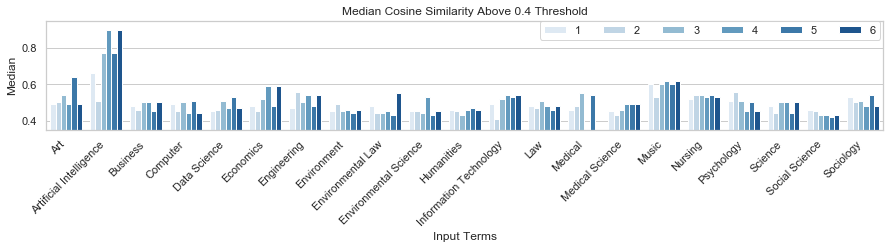

In [528]:
plt.figure(figsize=(15, 2))
sns.set_style("whitegrid")

median_barplot = sns.barplot(x="Input", 
                             hue="Model", 
                             y="value", 
                             data=median_df2_melt,palette='Blues')
# Produce Barplot
median_barplot.set_xticklabels(median_barplot.get_xticklabels(), 
                               rotation=45, horizontalalignment='right')
# Define Y-axis limits
median_barplot.set(ylim=(0.35,0.95),xlabel='Input Terms', ylabel='Median')

# Format Legend
plt.legend(bbox_to_anchor=(0.59, 1), loc=2, borderaxespad=0.,ncol=6)

# Set Title
plt.title("Median Cosine Similarity Above 0.4 Threshold")


##### Frequency count of recommendations with cosine similarities equal to or greater than 0.4 for all six models.

Text(0.5, 1.0, 'Count of Cosine Similarities Above 0.4 Threshold')

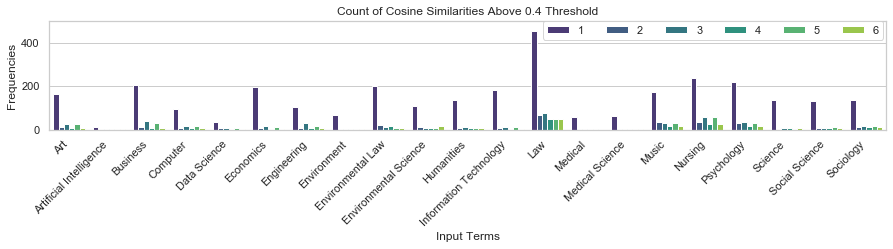

In [516]:
plt.figure(figsize=(15, 2))
sns.set_style("whitegrid")

count_barplot = sns.barplot(x="Input", 
                             hue="Model", 
                             y="value", 
                             data=count_df2_melt,palette='viridis')
# Produce Barplot
count_barplot.set_xticklabels(count_barplot.get_xticklabels(), 
                               rotation=45, horizontalalignment='right')
# Define Y-axis limits
count_barplot.set(ylim=(0,500),xlabel='Input Terms', ylabel='Frequencies')

# Format Legend
plt.legend(bbox_to_anchor=(0.59, 1), loc=2, borderaxespad=0.,ncol=6)

# Set Title
plt.title("Count of Cosine Similarities Above 0.4 Threshold")


##### Logarithm of frequency count of recommendations with cosine similarities equal to or greater than 0.4 for all six models.

In [536]:
count_df2_melt2 = count_df2_melt.copy()
count_df2_melt2['log_value'] = np.log(count_df2_melt['value'])

/Users/Tony/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Logarithmic Count of Cosine Similarities Above 0.4 Threshold')

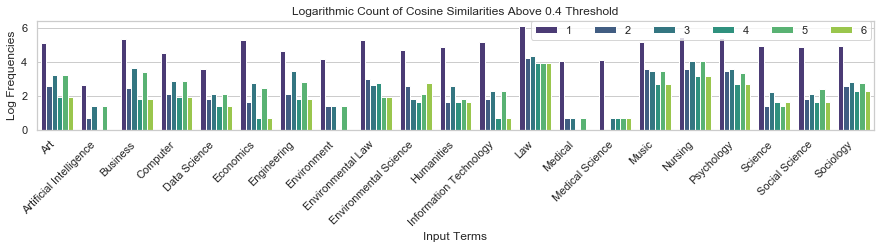

In [542]:
plt.figure(figsize=(15, 2))
sns.set_style("whitegrid")

count_barplot2 = sns.barplot(x="Input", 
                             hue="Model", 
                             y="log_value", 
                             data=count_df2_melt2,palette='viridis')
# Produce Barplot
count_barplot2.set_xticklabels(count_barplot2.get_xticklabels(), 
                               rotation=45, horizontalalignment='right')
# Define Y-axis limits
count_barplot2.set(xlabel='Input Terms', ylabel='Log Frequencies')
ax.set(yscale="log")

# Format Legend
plt.legend(bbox_to_anchor=(0.59, 1), loc=2, borderaxespad=0.,ncol=6)

# Set Title
plt.title("Logarithmic Count of Cosine Similarities Above 0.4 Threshold")

##### Interquartile range of recommendations with cosine similarities equal to or greater than 0.4 for all six models.

Text(0.5, 1.0, 'Interquartile Ranges of Cosine Similarities Above 0.4 Threshold')

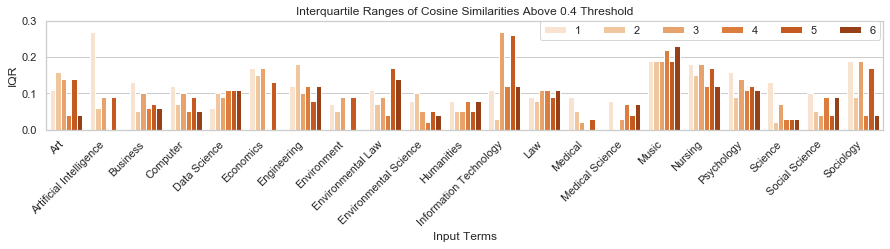

In [517]:
plt.figure(figsize=(15, 2))
sns.set_style("whitegrid")

IQR_barplot = sns.barplot(x="Input", 
                             hue="Model", 
                             y="value", 
                             data=IQR_df2_melt,palette='Oranges')
# Produce Barplot
IQR_barplot.set_xticklabels(count_barplot.get_xticklabels(), 
                               rotation=45, horizontalalignment='right')
# Define Y-axis limits
IQR_barplot.set(ylim=(0,0.30),xlabel='Input Terms', ylabel='IQR')

# Format Legend
plt.legend(bbox_to_anchor=(0.59, 1), loc=2, borderaxespad=0.,ncol=6)

# Set Title
plt.title("Interquartile Ranges of Cosine Similarities Above 0.4 Threshold")


##### Minimum of recommendations with cosine similarities equal to or greater than 0.4 for all six models.

Text(0.5, 1.0, 'Minimum Values of Cosine Similarities Above 0.4 Threshold')

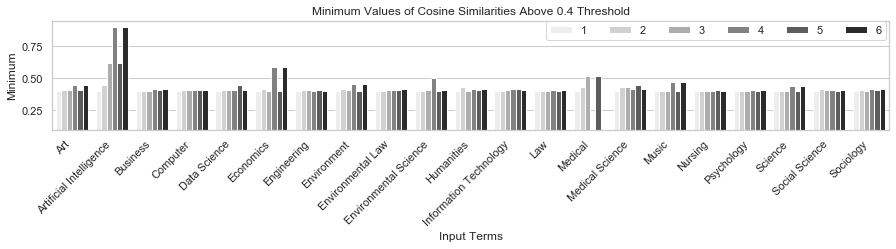

In [518]:
plt.figure(figsize=(15, 2))
sns.set_style("whitegrid")

min_barplot = sns.barplot(x="Input", 
                             hue="Model", 
                             y="value", 
                             data=min_df2_melt,palette='Greys')
# Produce Barplot
min_barplot.set_xticklabels(count_barplot.get_xticklabels(), 
                               rotation=45, horizontalalignment='right')
# Define Y-axis limits
min_barplot.set(ylim=(0.1,0.95),xlabel='Input Terms', ylabel='Minimum')

# Format Legend
plt.legend(bbox_to_anchor=(0.59, 1), loc=2, borderaxespad=0.,ncol=6)

# Set Title
plt.title("Minimum Values of Cosine Similarities Above 0.4 Threshold")


##### Maximum of recommendations with cosine similarities equal to or greater than 0.4 for all six models.

Text(0.5, 1.0, 'Maximum Values of Cosine Similarities Above 0.4 Threshold')

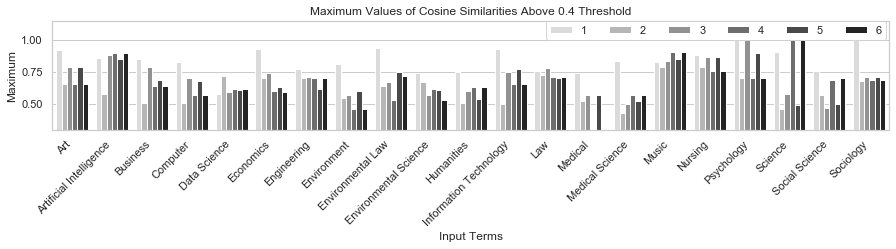

In [525]:
plt.figure(figsize=(15, 2))
sns.set_style("whitegrid")

max_barplot = sns.barplot(x="Input",
                          hue="Model",
                          y="value",
                          data=max_df2_melt,
                          palette='binary')
# Produce Barplot
max_barplot.set_xticklabels(max_barplot.get_xticklabels(),
                            rotation=45, 
                            horizontalalignment='right')
# Define Y-axis limits
max_barplot.set(ylim=(0.3,1.15),
                xlabel='Input Terms', 
                ylabel='Maximum')

# Format Legend
plt.legend(bbox_to_anchor=(0.59, 1), 
           loc=2, borderaxespad=0.,ncol=6)

# Set Title
plt.title("Maximum Values of Cosine Similarities Above 0.4 Threshold")


In [543]:
# Save Figures
max_barplot.figure.savefig("max_barplot.png",dpi=300, bbox_inches = "tight")
min_barplot.figure.savefig("min_barplot.png",dpi=300, bbox_inches = "tight")
IQR_barplot.figure.savefig("IQR_barplot.png",dpi=300, bbox_inches = "tight")
count_barplot.figure.savefig("count_barplot.png",dpi=300, bbox_inches = "tight")
median_barplot.figure.savefig("median_barplot.png",dpi=300, bbox_inches = "tight")
count_barplot2.figure.savefig("count_barplot2.png",dpi=300, bbox_inches = "tight")

### 10. References

Code cited:
1. McAllister, A., Naydenova, I., Duc, Q.N. (2019). Building a LDA-based Book Recommender System. Retrieved from https://humboldt-wi.github.io/blog/research/information_systems_1819/is_lda_final/ 
